# SECTION 1: DECLARE THE MODULES

In [72]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# SECTION 2: Data import and preprocess
#Run this but dont worry if it does not make any sense Jump to SECTION 3 that is related to your HD task.

In [73]:
!pip install wget
import wget
    
link_to_data = 'https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/training_attack_types.txt?raw=true'
DataSet = wget.download(link_to_data) 

100% [..............................................................] 500 / 500

In [74]:
DataSet

'training_attack_types (5).txt'

In [75]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names 
# file, but it is supposed to be a binary feature according to the 
# dataset documentation

# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [76]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open(DataSet, 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

In [77]:
attack_mapping

{'normal': 'benign',
 'apache2': 'dos',
 'back': 'dos',
 'mailbomb': 'dos',
 'processtable': 'dos',
 'snmpgetattack': 'dos',
 'teardrop': 'dos',
 'smurf': 'dos',
 'land': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'udpstorm': 'dos',
 'ps': 'u2r',
 'buffer_overflow': 'u2r',
 'perl': 'u2r',
 'rootkit': 'u2r',
 'loadmodule': 'u2r',
 'xterm': 'u2r',
 'sqlattack': 'u2r',
 'httptunnel': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'snmpguess': 'r2l',
 'imap': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'multihop': 'r2l',
 'phf': 'r2l',
 'named': 'r2l',
 'sendmail': 'r2l',
 'xlock': 'r2l',
 'xsnoop': 'r2l',
 'worm': 'probe',
 'nmap': 'probe',
 'ipsweep': 'probe',
 'portsweep': 'probe',
 'satan': 'probe',
 'mscan': 'probe',
 'saint': 'probe'}

In [78]:
#Processing Training Data
train_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTrain%2B.txt'

train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)

In [79]:
#Processing test Data
test_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTest%2B.txt'

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

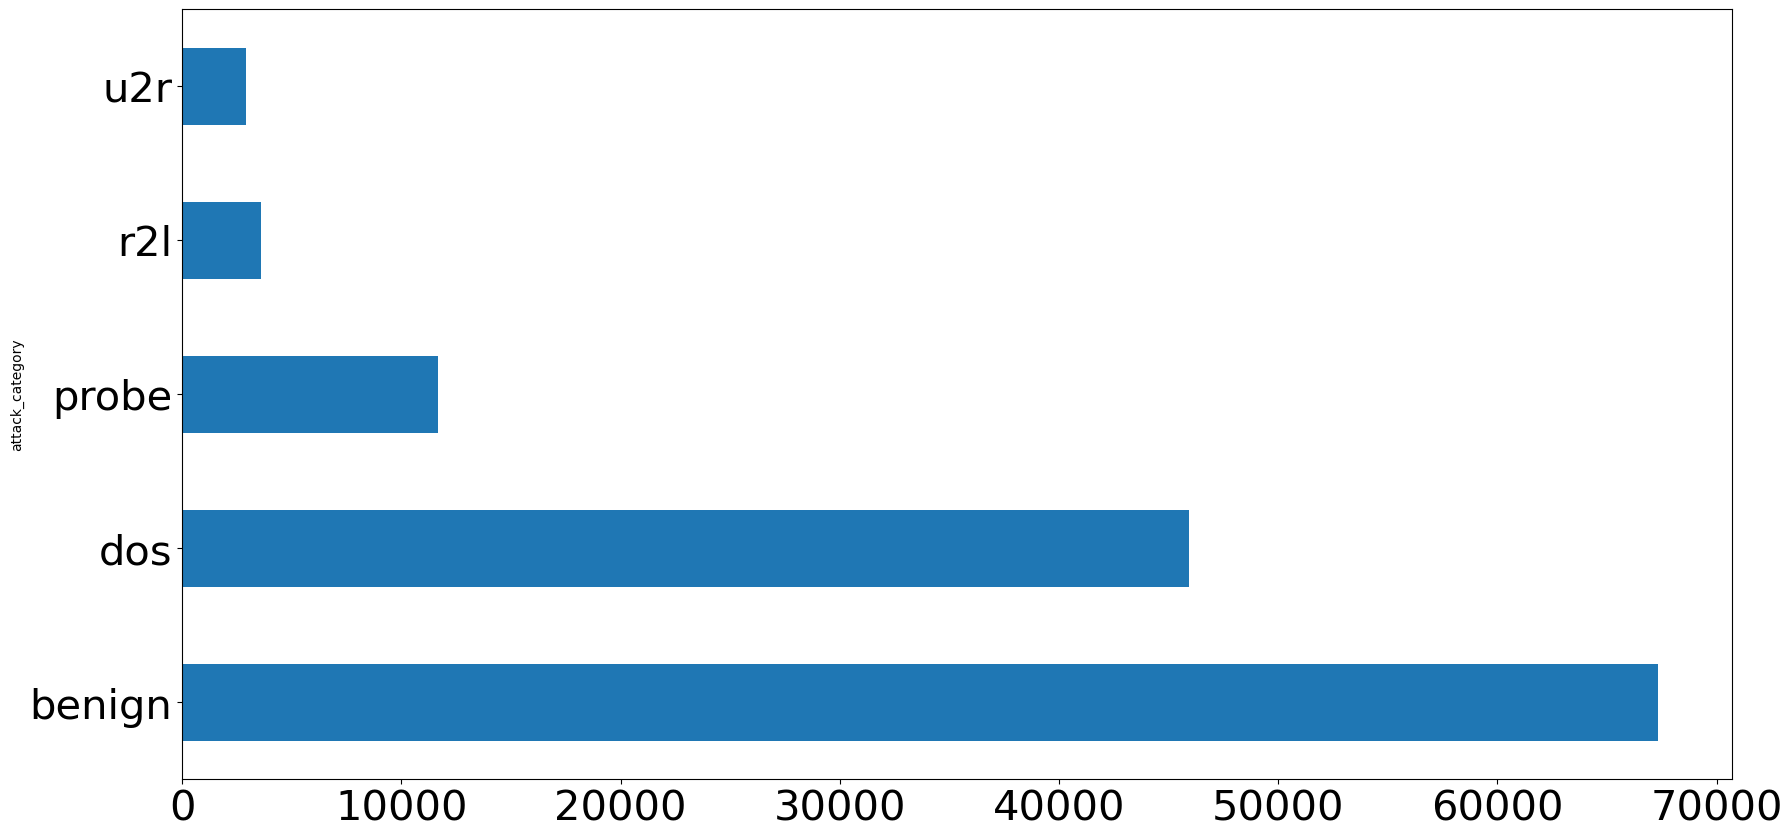

In [80]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

train_df[binary_cols].describe().transpose()
train_df.groupby(['su_attempted']).size()
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()
train_df.groupby(['num_outbound_cmds']).size()

#Now, that's not a very useful feature - let's drop it from the dataset
train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

#Data Preparation
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)


combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

#execute the commands in console
train_x.describe()
train_x['duration'].describe()
# Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

# Experimenting with MinMaxScaler on the single 'duration' feature
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

# Experimenting with RobustScaler on the single 'duration' feature
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Experimenting with MaxAbsScaler on the single 'duration' feature
from sklearn.preprocessing import MaxAbsScaler

max_Abs_scaler = MaxAbsScaler().fit(durations)
robust_scaled_durations = max_Abs_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Let's proceed with StandardScaler- Apply to all the numeric columns
standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])
    
train_x.describe()

train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

In [81]:
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score
from sklearn import metrics
import timeit

def performance_measures_and_classification_report(test_Y, pred_y, train_time, test_time):
    results = confusion_matrix(test_Y, pred_y)
    error = zero_one_loss(test_Y, pred_y)
    accuracy = accuracy_score(test_Y, pred_y)
    precision = precision_score(test_Y, pred_y, average='weighted')
    recall = recall_score(test_Y, pred_y, average='weighted')
    f1 = f1_score(test_Y, pred_y, average='weighted')
    mcc = matthews_corrcoef(test_Y, pred_y)
    cohens_kappa = cohen_kappa_score(test_Y, pred_y)

    print("Confusion matrix: ", results)
    
    print("Zero-one classification loss: ", error)
    print("Accuracy score: ", accuracy)
    print("Precision score: ", precision)
    print("Recall score: ", recall)
    print("F1 Score: ", f1)
    print("MCC: ", mcc)
    print("Cohens kappa:", cohens_kappa)
    print('Train Time(s): ',train_time) 
    print('Test Time(s): ',test_time)

    print("Classification Report : \n\n", metrics.classification_report(pred_y, test_Y))

In [82]:
import seaborn as sns
from matplotlib import pyplot as plt

def plot_confusion_matrix(test_Y,pred_y, name):
    con_metrix = confusion_matrix(y_true=test_Y,y_pred=pred_y)
    
    fig,ax = plt.subplots(figsize=(5,4))
    sns.heatmap(con_metrix,annot=True,cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig(name)
    plt.show()

# SECTION 3: Multi class classification
This is the section where you have to add other algorithms, tune algorithms and visualize to compare and analyze algorithms

Confusion matrix:  [[9365   56  289    1    0]
 [1541 5998   97    0    0]
 [ 677  220 1526    0    0]
 [2278    1   14  277    4]
 [ 175    0    5    5   15]]
Zero-one classification loss:  0.2378903477643719
Accuracy score:  0.7621096522356281
Precision score:  0.8148668083524764
Recall score:  0.7621096522356281
F1 Score:  0.7305335642990765
MCC:  0.6519347552489164
Cohens kappa: 0.6205180589531963
Train Time(s):  1.7244906189989706
Test Time(s):  0.03014223799982574
Classification Report : 

               precision    recall  f1-score   support

      benign       0.96      0.67      0.79     14036
         dos       0.79      0.96      0.86      6275
       probe       0.63      0.79      0.70      1931
         r2l       0.11      0.98      0.19       283
         u2r       0.07      0.79      0.14        19

    accuracy                           0.76     22544
   macro avg       0.51      0.84      0.54     22544
weighted avg       0.87      0.76      0.79     22544



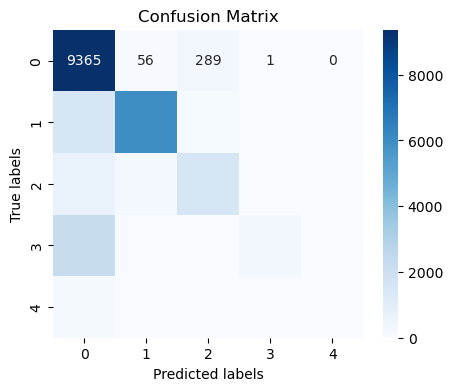

In [83]:
# 5-class classification version
# 1. Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix, zero_one_loss

start = timeit.default_timer()

decision_tree_classifier = DecisionTreeClassifier(random_state=17)
decision_tree_classifier.fit(train_x, train_Y)

stop = timeit.default_timer()
train_time= stop - start

start = timeit.default_timer()

pred_y = decision_tree_classifier.predict(test_x)

stop = timeit.default_timer()
test_time= stop - start

performance_measures_and_classification_report(test_Y, pred_y, train_time, test_time)

plot_confusion_matrix(test_Y,pred_y, 'decision_tree_multi_class.png')

Confusion matrix:  [[6756   62   10 2599  284]
 [3400 3162    4 1041   29]
 [1382  345  237  323  136]
 [1113    3    6  933  519]
 [ 115    0    0   22   63]]
Zero-one classification loss:  0.5053672817601136
Accuracy score:  0.49463271823988647
Precision score:  0.6491192048215554
Recall score:  0.49463271823988647
F1 Score:  0.4984205875192054
MCC:  0.26692374469181684
Cohens kappa: 0.25226919803751213
Train Time(s):  0.6153110660015955
Test Time(s):  0.16384200800166582
Classification Report : 

               precision    recall  f1-score   support

      benign       0.70      0.53      0.60     12766
         dos       0.41      0.89      0.56      3572
       probe       0.10      0.92      0.18       257
         r2l       0.36      0.19      0.25      4918
         u2r       0.32      0.06      0.10      1031

    accuracy                           0.49     22544
   macro avg       0.38      0.52      0.34     22544
weighted avg       0.55      0.49      0.49     22544



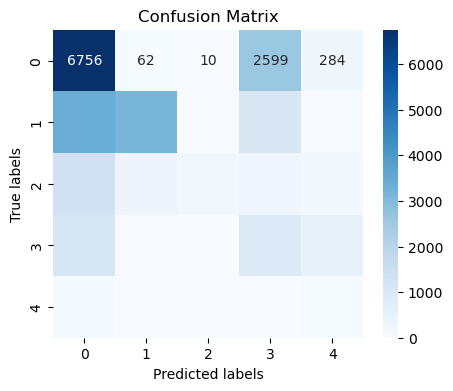

In [84]:
# 2. Naïve Bayes Classifier
from sklearn.naive_bayes import GaussianNB 

start = timeit.default_timer()

naive_bayes_classifier = GaussianNB().fit(train_x, train_Y) 

stop = timeit.default_timer()
train_time= stop - start

start = timeit.default_timer()

pred_y = naive_bayes_classifier.predict(test_x)

stop = timeit.default_timer()
test_time= stop - start

performance_measures_and_classification_report(test_Y, pred_y, train_time, test_time)

plot_confusion_matrix(test_Y,pred_y, 'naïve_bayes_multi_class.png')

Confusion matrix:  [[9007  300  401    1    2]
 [1679 5947   10    0    0]
 [ 539  106 1754   24    0]
 [2522    3    1   48    0]
 [ 182    4    0    3   11]]
Zero-one classification loss:  0.2562544357700497
Accuracy score:  0.7437455642299503
Precision score:  0.7619170438461841
Recall score:  0.7437455642299503
F1 Score:  0.7033015044863971
MCC:  0.6211344185974936
Cohens kappa: 0.5916782193306498
Train Time(s):  75.01115263899919
Test Time(s):  0.061025701001199195
Classification Report : 

               precision    recall  f1-score   support

      benign       0.93      0.65      0.76     13929
         dos       0.78      0.94      0.85      6360
       probe       0.72      0.81      0.76      2166
         r2l       0.02      0.63      0.04        76
         u2r       0.06      0.85      0.10        13

    accuracy                           0.74     22544
   macro avg       0.50      0.77      0.50     22544
weighted avg       0.86      0.74      0.78     22544



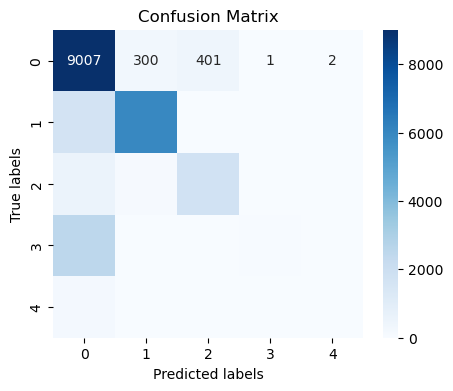

In [85]:
# 3. Logistic Regression
from sklearn.linear_model import LogisticRegression

start = timeit.default_timer()

logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(train_x, train_Y)

stop = timeit.default_timer()
train_time= stop - start

start = timeit.default_timer()

pred_y = logistic_regression.predict(test_x)

stop = timeit.default_timer()
test_time= stop - start

performance_measures_and_classification_report(test_Y, pred_y, train_time, test_time)

plot_confusion_matrix(test_Y,pred_y, 'logistic_regression_multi_class.png')

Confusion matrix:  [[9040  225  437    4    5]
 [1445 6179   12    0    0]
 [ 720  115 1588    0    0]
 [2291    1    2  275    5]
 [ 180    1    0    3   16]]
Zero-one classification loss:  0.2415720369056068
Accuracy score:  0.7584279630943932
Precision score:  0.806194897901349
Recall score:  0.7584279630943932
F1 Score:  0.7284289265696258
MCC:  0.6426126120488522
Cohens kappa: 0.6162793911391832
Train Time(s):  126.02906103100031
Test Time(s):  8.968752756998583
Classification Report : 

               precision    recall  f1-score   support

      benign       0.93      0.66      0.77     13676
         dos       0.81      0.95      0.87      6521
       probe       0.66      0.78      0.71      2039
         r2l       0.11      0.98      0.19       282
         u2r       0.08      0.62      0.14        26

    accuracy                           0.76     22544
   macro avg       0.52      0.80      0.54     22544
weighted avg       0.86      0.76      0.79     22544



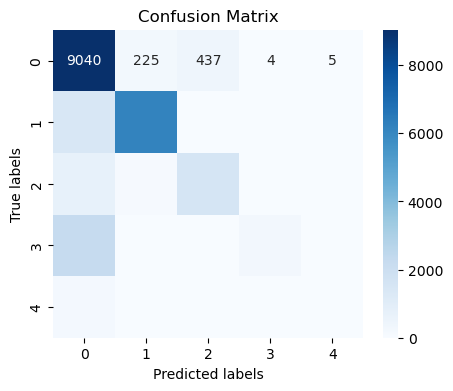

In [86]:
# 4. SVM (Support Vector Machine) Classifier
from sklearn.svm import SVC 

start = timeit.default_timer()

svm_linear_classifier = SVC(kernel = 'linear', C = 1)
svm_linear_classifier.fit(train_x, train_Y) 


stop = timeit.default_timer()
train_time= stop - start

start = timeit.default_timer()

pred_y = svm_linear_classifier.predict(test_x) 

stop = timeit.default_timer()
test_time= stop - start

performance_measures_and_classification_report(test_Y, pred_y, train_time, test_time)

plot_confusion_matrix(test_Y,pred_y, 'svm_multi_class.png')

Confusion matrix:  [[9443   55  210    2    1]
 [1610 5937   89    0    0]
 [ 595  180 1648    0    0]
 [2347    2   53  171    1]
 [ 105    0   85    4    6]]
Zero-one classification loss:  0.2368257629524485
Accuracy score:  0.7631742370475515
Precision score:  0.8161105919844542
Recall score:  0.7631742370475515
F1 Score:  0.7261809838665667
MCC:  0.6552507832797024
Cohens kappa: 0.6222774967652198
Train Time(s):  0.4100674049986992
Test Time(s):  6.701372352999897
Classification Report : 

               precision    recall  f1-score   support

      benign       0.97      0.67      0.79     14100
         dos       0.78      0.96      0.86      6174
       probe       0.68      0.79      0.73      2085
         r2l       0.07      0.97      0.12       177
         u2r       0.03      0.75      0.06         8

    accuracy                           0.76     22544
   macro avg       0.51      0.83      0.51     22544
weighted avg       0.88      0.76      0.80     22544



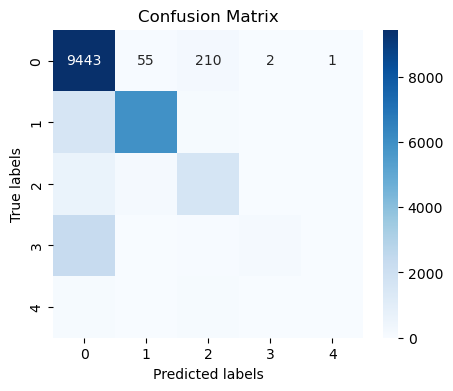

In [87]:
# 5. KNN (k-Nearest Neighbors) Classifier
from sklearn.neighbors import KNeighborsClassifier 

start = timeit.default_timer()

knn_classifier = KNeighborsClassifier(n_neighbors = 7)
knn_classifier.fit(train_x, train_Y) 

stop = timeit.default_timer()
train_time= stop - start

start = timeit.default_timer()

pred_y = knn_classifier.predict(test_x) 

stop = timeit.default_timer()
test_time= stop - start

performance_measures_and_classification_report(test_Y, pred_y, train_time, test_time)

plot_confusion_matrix(test_Y,pred_y, 'knn_multi_class.png')

In [88]:
!pip install tensorflow

In [89]:
print(train_x.shape)

(125973, 118)


Epoch 1/5
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9613 - loss: 0.1988 - val_accuracy: 0.7409 - val_loss: 1.7562
Epoch 2/5
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9925 - loss: 0.0245 - val_accuracy: 0.7275 - val_loss: 2.0610
Epoch 3/5
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9934 - loss: 0.0201 - val_accuracy: 0.7563 - val_loss: 2.2237
Epoch 4/5
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9945 - loss: 0.0171 - val_accuracy: 0.7514 - val_loss: 2.3189
Epoch 5/5
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9947 - loss: 0.0160 - val_accuracy: 0.7540 - val_loss: 2.7353
705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step
Confusion matrix:  [[9369  114  224    1    3]
 [1689 5918   29    0    0]
 [ 697  285 1441    0    0]
 [2319    0    6  246    3]
 [ 167    0    1    8   24]]
Zero-one classification loss:  0.24600780695528746
Accuracy score:  0.7539921930447125
Precision score:  0.809006583863575
Recall score:  0.753992193044

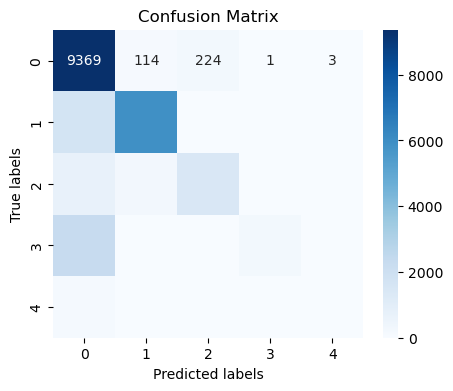

In [90]:
# 6. Keras
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_Y_encoded = label_encoder.fit_transform(train_Y)
test_Y_encoded = label_encoder.transform(test_Y)

start = timeit.default_timer()
input_shape = (118,)

model = models.Sequential([
    layers.Flatten(input_shape=(118,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(40, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_x, train_Y_encoded, epochs=5, validation_data=(test_x, test_Y_encoded))

stop = timeit.default_timer()
train_time= stop - start

start = timeit.default_timer()

pred_y = model.predict(test_x)

stop = timeit.default_timer()
test_time= stop - start

pred_y_labels = np.argmax(pred_y, axis=1)
pred_y_labels = pred_y_labels.astype(float)

performance_measures_and_classification_report(test_Y_encoded, pred_y_labels, train_time, test_time)

plot_confusion_matrix(test_Y_encoded, pred_y_labels, 'keras_multi_class.png')

Confusion matrix:  [[9458   67  185    0    1]
 [1773 5799   64    0    0]
 [ 802  163 1458    0    0]
 [2468    0    2  103    1]
 [ 193    0    2    4    1]]
Zero-one classification loss:  0.2539478353442157
Accuracy score:  0.7460521646557843
Precision score:  0.8075087728218459
Recall score:  0.7460521646557843
F1 Score:  0.706027852299268
MCC:  0.6313371686128489
Cohens kappa: 0.5903748506324378
Train Time(s):  103.96188250800333
Test Time(s):  2.5185959779992118
Classification Report : 

               precision    recall  f1-score   support

      benign       0.97      0.64      0.78     14694
         dos       0.76      0.96      0.85      6029
       probe       0.60      0.85      0.71      1711
         r2l       0.04      0.96      0.08       107
         u2r       0.01      0.33      0.01         3

    accuracy                           0.75     22544
   macro avg       0.48      0.75      0.48     22544
weighted avg       0.88      0.75      0.79     22544



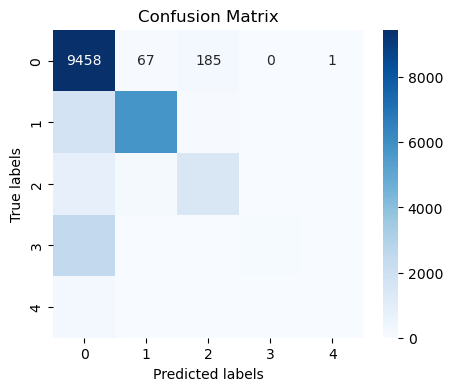

In [91]:
# 7. Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

start = timeit.default_timer()

rf_classifier = RandomForestClassifier(n_estimators = 1000, random_state=10)
rf_classifier.fit(train_x, train_Y)

stop = timeit.default_timer()
train_time= stop - start

start = timeit.default_timer()

pred_y = rf_classifier.predict(test_x)

stop = timeit.default_timer()
test_time= stop - start

performance_measures_and_classification_report(test_Y, pred_y, train_time, test_time)

plot_confusion_matrix(test_Y,pred_y, 'random_forest_multiclass.png')